In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.dates import date2num, DateFormatter
from statsmodels.tsa import ar_model, arima_model
import os

%matplotlib notebook

In [2]:
def MSE(Vals,Pred,WndwDys,DyStps):
    Resid = (abs(Pred - Vals))**2/(WndwDys*DyStps)
    return Resid.rolling(WndwDys*DyStps,center=False).sum()

## HTM Prediction

In [3]:
WndwDys = 30
DyStps = 1
PredAhead = 7

InputName = 'E:\\MyDocuments\\GitHub\\HTM\\Tests\\appts\\appt_htm_7steps_fac47_out.csv'
appt_htm = pd.read_csv(InputName, na_values="",index_col=0,usecols=[0,1,2])
appt_htm.index = pd.to_datetime(appt_htm.index, format = "%Y-%m-%d %H:%M:%S", errors = 'coerce') 
appt_htm['MSE'] = MSE(appt_htm.Ct,appt_htm.prediction,WndwDys,DyStps)

In [5]:
appt = appt_htm[['Ct','prediction']]
appt.rename(columns = {"prediction":"HTM"},inplace=True)
appt_mse = pd.DataFrame(appt_htm.MSE)
appt_mse.rename(columns = {"MSE":"HTM"},inplace=True)

E:\Anaconda3\envs\HTM\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Mean Ct over past 30 days per time step

In [6]:
appt_mn = appt_htm[['Ct']]
appt_mn['prediction'] = appt_mn.Ct.rolling(WndwDys,center=False).mean()
appt_mn.prediction = appt_mn.prediction.shift(PredAhead*DyStps)
appt_mn['MSE'] = MSE(appt_mn.Ct,appt_mn.prediction,WndwDys,DyStps)

appt['RollMn'] = appt_mn.prediction
appt_mse['RollMn'] = appt_mn.MSE

E:\Anaconda3\envs\HTM\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\envs\HTM\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## AR Model

In [7]:
appt_ar = appt_htm[['Ct']]
ar_mdl = ar_model.AR(appt_ar)
ar_fit = ar_mdl.fit(maxlag=(WndwDys*DyStps))
appt_ar['prediction'] = ar_fit.predict()
appt_ar['MSE'] = MSE(appt_ar.Ct,appt_ar.prediction,WndwDys,DyStps)


appt['AR'] = appt_ar.prediction
appt_mse['AR'] = appt_ar.MSE

E:\Anaconda3\envs\HTM\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Plots

In [51]:
df.head()

SHOW   MARRIED      MALE  AGE_0_54  DIST_0_30  \
APPOINTMENTDATETIME                                                      
2010-01-01           0.942029  0.434783  0.202899  0.942029   0.797101   
2010-01-02           0.942492  0.345048  0.277955  0.795527   0.837061   
2010-01-03           0.967033  0.494505  0.175824  0.879121   0.824176   
2010-01-04           0.771788  0.306161  0.315177  0.634298   0.643313   
2010-01-05           0.795588  0.301471  0.349081  0.587316   0.637500   

                        dates  
APPOINTMENTDATETIME            
2010-01-01           733773.0  
2010-01-02           733774.0  
2010-01-03           733775.0  
2010-01-04           733776.0  
2010-01-05           733777.0

E:\Anaconda3\envs\HTM\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


<IPython.core.display.Javascript object>


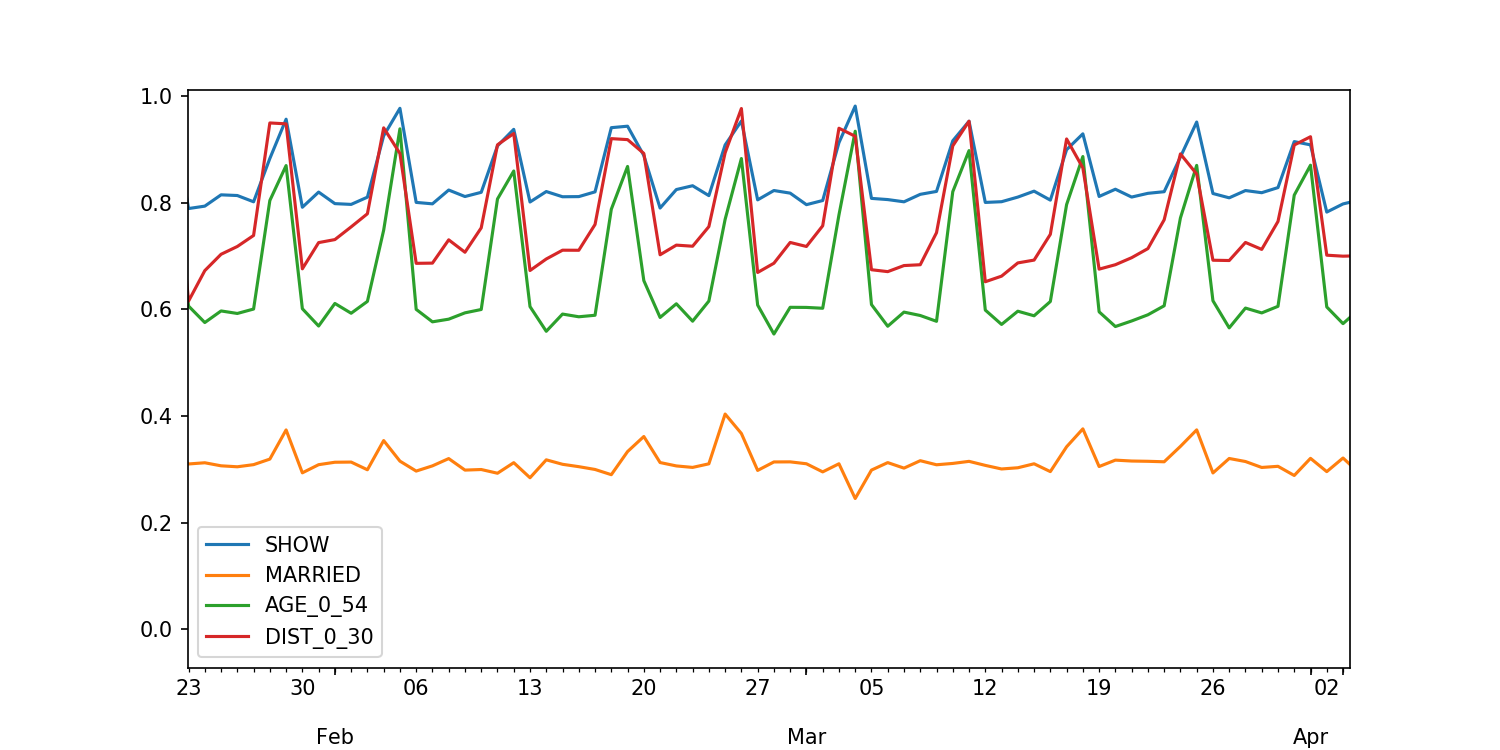

In [52]:
df = pd.read_csv(os.getcwd()+'\\Tests\\Appts\\appt_d.csv',index_col=0)
df.index = pd.to_datetime(df.index, format = "%Y-%m-%d", errors = 'coerce') 
df['dates'] = [date2num(date) for date in df.index]
df.plot(y=['SHOW','MARRIED', 'AGE_0_54', 'DIST_0_30'], figsize=(10,5))

<IPython.core.display.Javascript object>


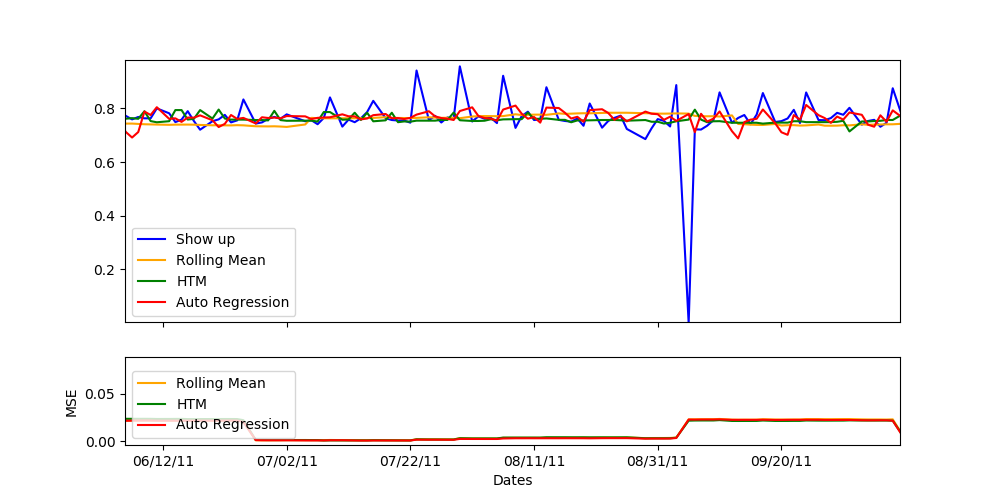

E:\Anaconda3\envs\HTM\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


In [30]:
appt['dates'] = [date2num(date) for date in appt.index]
appt_mse['dates'] = [date2num(date) for date in appt_mse.index]
gs = gridspec.GridSpec(2,1, height_ratios=[3, 1]) 
plt.figure(figsize=(10,5))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax0.set_prop_cycle('color',['b', 'orange','g','r'])
ax1.set_prop_cycle('color',['orange','g','r'])
MainGraph = appt.plot(x = 'dates',y = ['Ct','RollMn','HTM','AR'], ax = ax0)
AnomalyGraph = appt_mse.plot(x = 'dates', y=['RollMn','HTM','AR'], ax=ax1)
dateFormatter = DateFormatter('%m/%d/%y')
MainGraph.xaxis.set_major_formatter(dateFormatter)    
AnomalyGraph.xaxis.set_major_formatter(dateFormatter)
ax1.set_xlabel('Dates')
ax1.set_ylabel('MSE')
# ax0.set_ylabel('Traige Cts')
MainGraph.legend(tuple(['Show up','Rolling Mean','HTM','Auto Regression']), loc=3)
AnomalyGraph.legend(tuple(['Rolling Mean','HTM','Auto Regression']), loc=3)